#### For this challenge, you will be predicting a full year worth of sales for three items at two stores located in three different countries. This dataset is completely fictional, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc. The dataset is small enough to allow you to try numerous different modeling approaches. Submissions are evaluated on SMAPE between forecasts and actual values. 

#### Link to competition: https://www.kaggle.com/c/tabular-playground-series-jan-2022

In [1]:
# Загрузка библиотек
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import dateutil.easter as easter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sns.set_theme(style="darkgrid")
import warnings                                                   
warnings.filterwarnings('ignore')

In [2]:
# Загрузка данных
train = pd.read_csv(r"C:\Users\uckfo\Kaggle\tabular-playground-series-jan-2022\train.csv", parse_dates=['date'])
test = pd.read_csv(r"C:\Users\uckfo\Kaggle\tabular-playground-series-jan-2022\test.csv", parse_dates=['date'])
submission = pd.read_csv(r"C:\Users\uckfo\Kaggle\tabular-playground-series-jan-2022\sample_submission.csv")
nordic_holidays = pd.read_csv(r"C:\Users\uckfo\Kaggle\tabular-playground-series-jan-2022\nordic_holidays.csv", 
                              parse_dates=['date'], 
                              usecols=['date', 'country', 'holiday'])
gdp = pd.read_csv(r"C:\Users\uckfo\Kaggle\tabular-playground-series-jan-2022\GDP_data_2015_to_2019_Finland_Norway_Sweden.csv")
gdp = np.concatenate([gdp[['year', 'GDP_Finland']].values, 
                      gdp[['year', 'GDP_Norway']].values, 
                      gdp[['year', 'GDP_Sweden']].values])
gdp = pd.DataFrame(gdp, columns=['year', 'gdp'])
gdp['country'] = ['Finland'] * 5 + ['Norway'] * 5 + ['Sweden'] * 5

In [3]:
SEED = 25

In [4]:
def get_smape_score(X, y, ratio=0.8):

    def smape(true, predict):
        return (np.abs(true - predict) / (true + np.abs(predict)) * 200).mean()
    
    train_len = int(X.shape[0] * ratio)

    X_train = X[:train_len]
    X_valid = X[train_len:]
    y_train = y[:train_len]
    y_valid = y[train_len:]

    linreg = LinearRegression(n_jobs=-1)
    linreg.fit(X_train, y_train)
    
    return smape(np.array(y_valid), linreg.predict(X_valid))

In [5]:
def replace_space_and_lower(df):
    
    df.columns = [i.replace(' ', '_').lower() for i in df.columns]
    return df

In [6]:
def scale_features(df, scaler=None):
    
    if scaler is not None:
        df_scaled = pd.DataFrame(scaler.transform(df.values), columns=(df.columns + '_scaled'))
        return df_scaled
    else:
        scaler = StandardScaler()
        scaler.fit(df.values)
        df_scaled = pd.DataFrame(scaler.transform(df.values), columns=(df.columns + '_scaled'))
        return scaler, df_scaled

In [7]:
def preprocessing(df):
    
    # Создание новых признаков
    df['month'] = df['date'].apply(lambda ts: ts.month)
    df['day'] = df['date'].apply(lambda ts: ts.day)
    df['day_of_week'] = df['date'].apply(lambda ts: ts.dayofweek)
    df['year'] = df['date'].apply(lambda ts: ts.year)
    df['year_month'] = df['date'].apply(lambda ts: 100 * ts.year + ts.month)
    df['wd4'] = df['date'].apply(lambda ts: 1 if ts.dayofweek == 4 else 0)
    df['wd56'] = df['date'].apply(lambda ts: 1 if ts.dayofweek in (5, 6) else 0)
    df['day_of_year'] = df['date'].apply(lambda ts: ts.dayofyear)
    df['quarter'] = df['date'].apply(lambda ts: ts.quarter)

    # Создание признака Holiday и применение к нему One Hot Encoding
    holiday_dummies = pd.get_dummies(df.merge(nordic_holidays, on=['date', 'country'], how='left').sort_values('row_id')['holiday'])
    for col in holiday_dummies.columns:
        hol = holiday_dummies[col].values + holiday_dummies[col].rolling(7).mean().fillna(0).values
        df['holiday_' + str(col)] = hol
    
    # Применение One Hot Encoding к остальным признакам
    features = ['country', 'store', 'product', 'month', 'day', 'day_of_week', 'quarter']
    for feature in features:
        dummies = pd.get_dummies(df[feature])
        for col in dummies.columns:
            df[feature + '_' + str(col)] = dummies[col]

    # Добавление прологарифмированного признака gdp
    df['log_gdp'] = np.log(df.merge(gdp, on=['country', 'year'], how='left')['gdp'])
            
    # Добавление эффекта сезонности
    for i in range(1,11):
        df[f'dateofweek_sin{i}'] = np.sin(2* np.pi * df['date'].dt.dayofweek / 7 * i)
        df[f'dateofweek_cos{i}'] = np.cos(2* np.pi * df['date'].dt.dayofweek / 7 * i)
        df[f'month_sin{i}'] = np.sin(2* np.pi * df['date'].dt.month / 12 * i)
        df[f'month_cos{i}'] = np.cos(2* np.pi * df['date'].dt.month / 12 * i)

    for i in range(1,5):
        df[f'dayofyear_sin{i}'] = np.sin(2* np.pi * df['date'].dt.dayofyear / 365 * i)
        df[f'dayofyear_cos{i}'] = np.cos(2* np.pi * df['date'].dt.dayofyear / 365 * i)
    
    for k in range(1, 3):
        df[f'sin{k}'] = np.sin(df['day_of_year'] / 365 * 2 * np.pi * k)
        df[f'cos{k}'] = np.cos(df['day_of_year'] / 365 * 2 * np.pi * k)
        df[f'mug_sin{k}'] = df[f'sin{k}'] * df['product_Kaggle Mug']
        df[f'mug_cos{k}'] = df[f'cos{k}'] * df['product_Kaggle Mug']
        df[f'hat_sin{k}'] = df[f'sin{k}'] * df['product_Kaggle Hat']
        df[f'hat_cos{k}'] = df[f'cos{k}'] * df['product_Kaggle Hat']
    
    # Добавление признаков, связанных с конкретными датами:
    # Конец декабря   
    df = pd.concat([df,
                        pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d)
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"n-dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) &
                                      (df.country == 'Norway')
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"f-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & 
                                      (df.country == 'Finland')
                                      for d in range(1, 14)}),
                        pd.DataFrame({f"jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) &
                                      (df.country == 'Norway')
                                      for d in range(1, 10)}),
                        pd.DataFrame({f"s-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & 
                                      (df.country == 'Sweden')
                                      for d in range(1, 15)})],
                       axis=1)
    
    # Май
    df = pd.concat([df,
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) 
                                      for d in list(range(1, 10))}),
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) & 
                                      (df.country == 'Norway')
                                      for d in list(range(18, 28))})],
                       axis=1)
    
    # Июнь и июль
    df = pd.concat([df,
                        pd.DataFrame({f"june{d}":
                                      (df.date.dt.month == 6) & (df.date.dt.day == d) & 
                                      (df.country == 'Sweden')
                                      for d in list(range(8, 14))}),
                       ],
                       axis=1)
        
    # Последняя среда июня
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})
    df = pd.concat([df,
                        pd.DataFrame({f"wed_june{d}": 
                                      (df.date - wed_june_date == np.timedelta64(d, "D")) & 
                                      (df.country != 'Norway')
                                      for d in list(range(-4, 6))})],
                       axis=1)
    
    # Первое воскресенье ноября
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
    
    df = pd.concat([df,
                        pd.DataFrame({f"sun_nov{d}": 
                                      (df.date - sun_nov_date == np.timedelta64(d, "D")) &
                                      (df.country != 'Norway')
                                      for d in list(range(0, 9))})],
                       axis=1)
    
    # Первая половина декабря
    df = pd.concat([df,
                        pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) &
                                      (df.country == 'Finland')
                                      for d in list(range(6, 14))})],
                       axis=1)
    
    # Пасха
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    df = pd.concat([df,
                        pd.DataFrame({f"easter{d}": 
                                      (df.date - easter_date == np.timedelta64(d, "D"))
                                      for d in list(range(-2, 11)) + list(range(40, 48)) +
                                      list(range(50, 59))})],
                       axis=1)
        
    df = df.drop(['country', 'store', 'product', 'month', 'day', 'day_of_week', 'date', 'quarter', 'num_sold'], axis=1).set_index('row_id').astype(np.float32)
    
    return df

In [8]:
processed_train_test = preprocessing(train.append(test))
X_train = processed_train_test.iloc[:len(train)].copy()
X_test = processed_train_test.iloc[len(train):].copy()
y_train = train['num_sold']

In [9]:
X_train = replace_space_and_lower(X_train)
scaler, X_train = scale_features(X_train)

In [10]:
X_test = replace_space_and_lower(X_test)
X_test = scale_features(X_test, scaler)

Выровняем распределение таргета с помощью логарифмирования. При предсказании будем брать экспоненту логарифма.

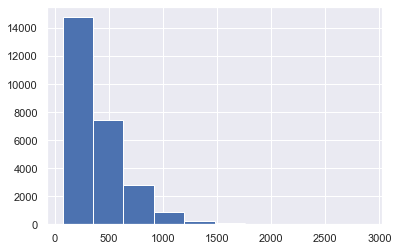

In [12]:
y_train.hist();

In [13]:
get_smape_score(X_train, y_train)

23.387094819896834

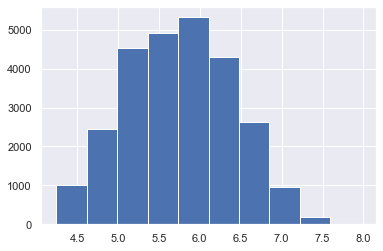

In [14]:
np.log(y_train).hist();

In [15]:
get_smape_score(X_train, np.log(y_train))

1.2174572507691008

In [16]:
linreg = LinearRegression(n_jobs=-1)
linreg.fit(X_train, np.log(y_train))

y_pred = np.exp(linreg.predict(X_test))
submission['num_sold'] = y_pred
submission.to_csv('linreg_log_target.csv', index=False)

### Final score - 4.975 (top 10%)